## Домашняя работа
Будем работать с датасетом подержанных машин https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes.

Задача - построить прогноз цены машины по ее данным (год выпуска, пробег, расход, размер двигателя, тип коробки передач и тд).

Это задача регрессии, поэтому нужно использовать модели регрессоры, а не классификаторы (например, не StackingClassifier, а StackingRegressor).

#### Easy
Взять один файл с маркой машины.

Построить прогноз, используя модели линейной регрессии и случайного леса.

Сравнить результаты, используя кросс-валидацию.

Подобрать гиперпараметры моделей (для линейной регрессии можно использовать реализацию с градиентным спуском SGDRegressor).

Оценить качество, используя метрику r2_score.

Оценить важность признаков (параметр feature_importance_ у случайного леса).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier, plot_tree
from mlxtend.plotting import category_scatter, plot_decision_regions
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_validate, cross_val_score
import scipy.stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
bmw = pd.read_csv(r'D:\Курсы Питон\Машины\bmw.csv', sep=',')
bmw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10781 non-null  object 
 1   year          10781 non-null  int64  
 2   price         10781 non-null  int64  
 3   transmission  10781 non-null  object 
 4   mileage       10781 non-null  int64  
 5   fuelType      10781 non-null  object 
 6   tax           10781 non-null  int64  
 7   mpg           10781 non-null  float64
 8   engineSize    10781 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 758.2+ KB


In [3]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
standard_bmw = scaler.fit_transform(bmw[['year', 'mileage', 'tax', 'mpg', 'engineSize']])
standard_bmw = pd.DataFrame(standard_bmw, columns =['year', 'mileage', 'tax', 'mpg', 'engineSize'])
standard_bmw

,year,mileage,tax,mpg,engineSize
0,-1.310782,1.653447,-0.108963,0.038326,-0.303911
1,0.392121,-0.424388,0.216199,-0.433982,-0.303911
2,-0.459331,1.483453,0.460070,-0.159533,1.507591
3,-0.033605,0.046894,0.216199,0.510634,-1.209662
4,-1.310782,0.559104,0.460070,-0.191445,1.507591
...,...,...,...,...,...
10776,-0.459331,0.609379,0.297489,-0.066986,-0.303911
10777,-0.459331,0.694058,-0.108963,0.118108,-0.303911
10778,-0.033605,-0.001153,1.110393,-0.433982,-0.303911
10779,-1.310782,0.775714,-1.653480,0.248950,-0.303911


In [4]:
bmw_cat = bmw[['transmission', 'fuelType', 'price']]
bmw_cat

,transmission,fuelType,price
0,Automatic,Diesel,11200
1,Automatic,Petrol,27000
2,Automatic,Diesel,16000
3,Automatic,Diesel,12750
4,Automatic,Diesel,14500
...,...,...,...
10776,Automatic,Diesel,19000
10777,Automatic,Diesel,14600
10778,Manual,Petrol,13100
10779,Automatic,Diesel,9930


In [5]:
bmw_all_c = pd.concat([standard_bmw, bmw_cat], axis=1)
bmw_all_c

,year,mileage,tax,mpg,engineSize,transmission,fuelType,price
0,-1.310782,1.653447,-0.108963,0.038326,-0.303911,Automatic,Diesel,11200
1,0.392121,-0.424388,0.216199,-0.433982,-0.303911,Automatic,Petrol,27000
2,-0.459331,1.483453,0.460070,-0.159533,1.507591,Automatic,Diesel,16000
3,-0.033605,0.046894,0.216199,0.510634,-1.209662,Automatic,Diesel,12750
4,-1.310782,0.559104,0.460070,-0.191445,1.507591,Automatic,Diesel,14500
...,...,...,...,...,...,...,...,...
10776,-0.459331,0.609379,0.297489,-0.066986,-0.303911,Automatic,Diesel,19000
10777,-0.459331,0.694058,-0.108963,0.118108,-0.303911,Automatic,Diesel,14600
10778,-0.033605,-0.001153,1.110393,-0.433982,-0.303911,Manual,Petrol,13100
10779,-1.310782,0.775714,-1.653480,0.248950,-0.303911,Automatic,Diesel,9930


In [6]:
import category_encoders as ce
encoder = ce.one_hot.OneHotEncoder(cols=['transmission', 'fuelType'])
bmw_all = encoder.fit_transform(bmw_all_c)
bmw_all.head(2)

,year,mileage,tax,mpg,engineSize,transmission_1,transmission_2,transmission_3,fuelType_1,fuelType_2,fuelType_3,fuelType_4,fuelType_5,price
0,-1.310782,1.653447,-0.108963,0.038326,-0.303911,1,0,0,1,0,0,0,0,11200
1,0.392121,-0.424388,0.216199,-0.433982,-0.303911,1,0,0,0,1,0,0,0,27000


In [7]:
bmw_all_corr = bmw_all.corr()
fig = bmw_all.corr()

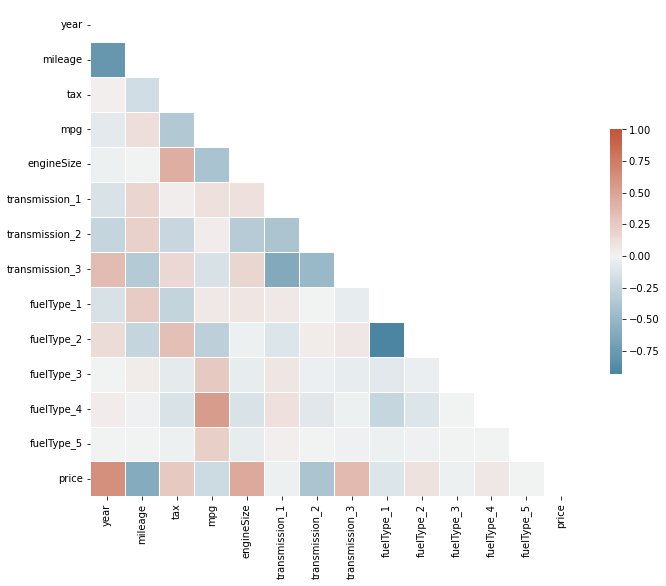

In [8]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(fig, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(fig, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

figure = ax.get_figure()    
figure.savefig('heatmap.png', dpi=400)

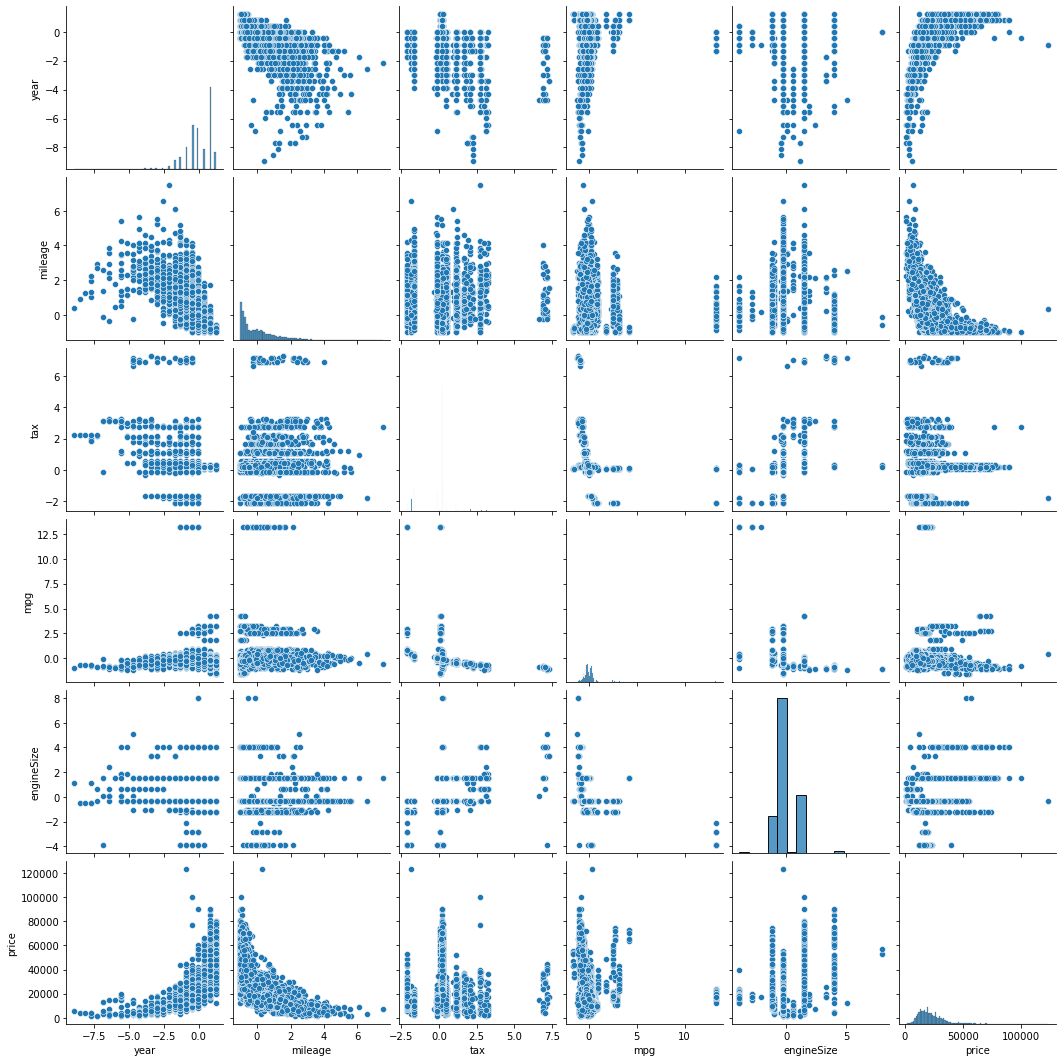

In [9]:
sns.pairplot(bmw_all_c)

In [10]:
X = bmw_all.drop(['price'], axis=1)
Y = bmw_all['price']

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8)

### Линейная регрессия

In [12]:
from sklearn.metrics import r2_score

model_lr = LinearRegression()
model_lr.fit(x_train, y_train)

y_pred = model_lr.predict(x_test)
r2_score(y_test, y_pred)

0.6826698850748094

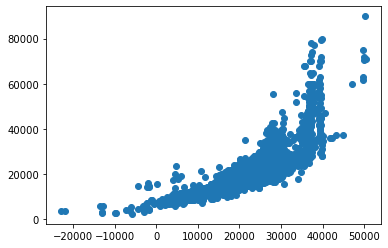

In [13]:
plt.scatter(y_pred, y_test)

### Случайный лес

In [14]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor()
model_rf.fit(x_train, y_train)
y_rf_pred = model_rf.predict(x_test)
r2_score(y_test, y_rf_pred)

0.9266589785003265

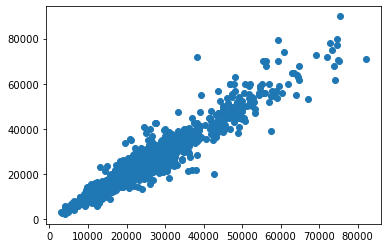

In [15]:
plt.scatter(y_rf_pred, y_test)

#### Сравнение результатов с использованием кросс-валидации

In [16]:
sample_lr = cross_validate(model_lr, x_train, y_train, scoring=['explained_variance', 'r2'], cv=100)
sample_rf = cross_validate(model_rf, x_train, y_train, scoring=['explained_variance', 'r2'], cv=100)

In [17]:
sample_lr['test_r2'].mean()

0.6623493777076795

In [18]:
sample_rf['test_r2'].mean()

0.9168706531395966

In [19]:
stat, pval = scipy.stats.ttest_ind(sample_lr['test_r2'], sample_rf['test_r2'])

print(stat, pval)

-24.657764989981672 2.857380393288985e-62


Модель случайного леса работает лучше, чем модель линейной регрессии.

### Оценка важности признаков (параметр feature_importance_ )

In [20]:
fi = pd.DataFrame({'Параметр': list(x_train.columns),
                   'Важность': model_rf.feature_importances_}).\
                    sort_values('Важность', ascending = False)
fi.head()

,Параметр,Важность
0,year,0.434482
4,engineSize,0.263062
3,mpg,0.142695
1,mileage,0.102179
6,transmission_2,0.016843


Наиболее важным параметром является год выпуска машины, на втором месте - размер двигателя.

### Подбор гиперпараметров

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
params = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000]}

In [ ]:
search = GridSearchCV(RandomForestRegressor(), params)
search.fit(x_train, y_train)
print('Best Params: ', search.best_estimator_)

Случайный лес RandomForestRegressor(max_depth=40, min_samples_leaf=2, min_samples_split=5, n_estimators=400)

In [24]:
model_rf2 = RandomForestRegressor(max_depth=40, min_samples_leaf=2, min_samples_split=5, n_estimators=400)
model_rf2.fit(x_train, y_train)
y_rf2_pred = model_rf2.predict(x_test)
r2_score(y_test, y_rf2_pred)

0.9273924665988039

для линейной регрессии

In [29]:
from sklearn.linear_model import SGDRegressor

param_lr = {
    'alpha': 10.0 ** -np.arange(1, 7),
    'loss': ['squared_error', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
}

In [28]:
search_lr = GridSearchCV(SGDRegressor(), param_lr)
search_lr.fit(x_train, y_train)
print('Best Params: ', search_lr.best_estimator_)

D:\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(
D:\anaconda3\lib\site-pa

Best Params:  SGDRegressor(alpha=0.1, loss='squared_loss', penalty='l1')


D:\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(


Best Params:  SGDRegressor(alpha=0.1, loss='squared_error', penalty='l1')

In [30]:
model_lrSDG = SGDRegressor(alpha=0.1, loss='squared_error', penalty='l1')
model_lrSDG.fit(x_train, y_train)

y_lrSDG_pred = model_lrSDG.predict(x_test)
r2_score(y_test, y_lrSDG_pred)

0.6783384034647071